In [1]:

import os, sys
import numpy as np
from numba import jit
import librosa
#from scipy import signal
from scipy import ndimage
from matplotlib import pyplot as plt
import IPython.display as ipd
import time

sys.path.append('..')
import libfmp.b
import libfmp.c2
import libfmp.c6

%matplotlib inline


In [2]:

@jit(nopython=True)
def compute_constellation_map_naive(Y, dist_freq=7, dist_time=7, thresh=0.01):
    """Compute constellation map (naive implementation)

    Notebook: C7/C7S1_AudioIdentification.ipynb

    Args:
        Y (np.ndarray): Spectrogram (magnitude)
        dist_freq (int): Neighborhood parameter for frequency direction (kappa) (Default value = 7)
        dist_time (int): Neighborhood parameter for time direction (tau) (Default value = 7)
        thresh (float): Threshold parameter for minimal peak magnitude (Default value = 0.01)

    Returns:
        Cmap (np.ndarray): Boolean mask for peak structure (same size as Y)
    """
    # spectrogram dimensions
    if Y.ndim > 1:
        (K, N) = Y.shape
    else:
        K = Y.shape[0]
        N = 1
    Cmap = np.zeros((K, N), dtype=np.bool8)

    # loop over spectrogram
    for k in range(K):
        f1 = max(k - dist_freq, 0)
        f2 = min(k + dist_freq + 1, K)
        for n in range(N):
            t1 = max(n - dist_time, 0)
            t2 = min(n + dist_time + 1, N)
            curr_mag = Y[k, n]
            curr_rect = Y[f1:f2, t1:t2]
            c_max = np.max(curr_rect)
            if ((curr_mag == c_max) and (curr_mag > thresh)):
                Cmap[k, n] = True
    return Cmap


In [3]:
def plot_constellation_map(Cmap, Y=None, xlim=None, ylim=None, title='',
                           xlabel='Time (sample)', ylabel='Frequency (bins)',
                           s=5, color='r', marker='o', figsize=(7, 3), dpi=72):
    """Plot constellation map

    Notebook: C7/C7S1_AudioIdentification.ipynb

    Args:
        Cmap: Constellation map given as boolean mask for peak structure
        Y: Spectrogram representation (Default value = None)
        xlim: Limits for x-axis (Default value = None)
        ylim: Limits for y-axis (Default value = None)
        title: Title for plot (Default value = '')
        xlabel: Label for x-axis (Default value = 'Time (sample)')
        ylabel: Label for y-axis (Default value = 'Frequency (bins)')
        s: Size of dots in scatter plot (Default value = 5)
        color: Color used for scatter plot (Default value = 'r')
        marker: Marker for peaks (Default value = 'o')
        figsize: Width, height in inches (Default value = (7, 3))
        dpi: Dots per inch (Default value = 72)

    Returns:
        fig: The created matplotlib figure
        ax: The used axes.
        im: The image plot
    """
    if Cmap.ndim > 1:
        (K, N) = Cmap.shape
    else:
        K = Cmap.shape[0]
        N = 1
    if Y is None:
        Y = np.zeros((K, N))
    fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=dpi)
    im = ax.imshow(Y, origin='lower', aspect='auto', cmap='gray_r', interpolation='nearest')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    Fs = 1
    if xlim is None:
        xlim = [-0.5/Fs, (N-0.5)/Fs]
    if ylim is None:
        ylim = [-0.5/Fs, (K-0.5)/Fs]
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    n, k = np.argwhere(Cmap == 1).T
    ax.scatter(k, n, color=color, s=s, marker=marker)
    plt.tight_layout()
    return fig, ax, im



In [4]:
def compute_spectrogram(fn, Fs=22050, duration=None, N=2048, H=1024, bin_max=128, frame_max=None):
    x, Fs = librosa.load(fn, sr=Fs, duration=duration, mono=True)
    x_duration = len(x) / Fs
    X = librosa.stft(x, n_fft=N, hop_length=H, win_length=N, window='hann')
    if bin_max is None:
        bin_max = X.shape[0]
    if frame_max is None:
        frame_max = X.shape[0]
    Y = np.abs(X[:bin_max, :frame_max])
    return Y



In [26]:

from ipyfilechooser import FileChooser

Fs = 22050
audio_path = './input_audio/'
# default_fn = 'Gloria Jones - Tainted Love (VN Project edited video) [EH4yq-goqiA].opus'
default_fn = 'Gnarls Barkley - Crazy (Official Video) [4K Remaster] [-N4jf6rtyuw].opus'
fdialog = FileChooser(audio_path,
   filename=default_fn,
   title='<b>song</b>',
   filter_pattern=['*.opus', '*.mp3'],
   select_default=True,
   show_only_dirs=False,
)

# fdialog.reset() # reset selection
fdialog.rows = 25
display(fdialog)





FileChooser(path='/home/kobi/tmpMusic', filename='Gnarls Barkley - Crazy (Official Video) [4K Remaster] [-N4jf…

In [27]:

duration = 20.0 #  seconds
Y = compute_spectrogram(fdialog.selected, duration=duration)


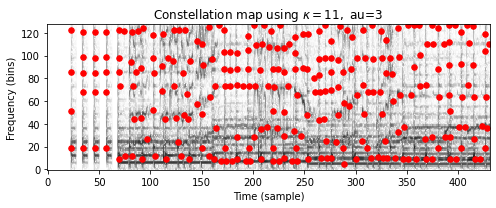

In [28]:


dist_freq = 11  # kappa: neighborhood in frequency direction
dist_time = 3   # tau: neighborhood in time direction
title=f'Constellation map using $\kappa=${dist_freq}$, $\tau=${dist_time}$'
Cmap_naive = compute_constellation_map_naive(Y, dist_freq, dist_time)
fig, ax, im = plot_constellation_map(Cmap_naive, np.log(1 + 1 * Y),
                                     color='r', s=30, title=title)

Runtime of naive (iterative) implementation: 0.01049816 seconds
Runtime of fast (scipy.ndimage) implementation: 0.00172373 seconds


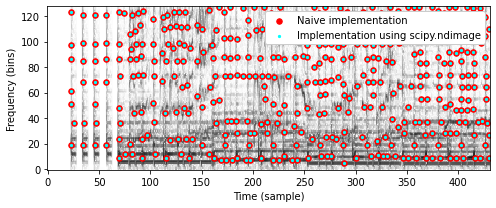

In [29]:
def compute_constellation_map(Y, dist_freq=7, dist_time=7, thresh=0.01):
    """Compute constellation map (implementation using image processing)

    Notebook: C7/C7S1_AudioIdentification.ipynb

    Args:
        Y (np.ndarray): Spectrogram (magnitude)
        dist_freq (int): Neighborhood parameter for frequency direction (kappa) (Default value = 7)
        dist_time (int): Neighborhood parameter for time direction (tau) (Default value = 7)
        thresh (float): Threshold parameter for minimal peak magnitude (Default value = 0.01)

    Returns:
        Cmap (np.ndarray): Boolean mask for peak structure (same size as Y)
    """
    result = ndimage.maximum_filter(Y, size=[2*dist_freq+1, 2*dist_time+1], mode='constant')
    Cmap = np.logical_and(Y == result, result > thresh)
    return Cmap


dist_freq = 7  # kappa: neighborhood in frequency direction
dist_time = 3  # tau: neighborhood in time direction

start = time.time()
for i in range(100):
    Cmap_naive = compute_constellation_map_naive(Y, dist_freq, dist_time)
end = time.time()
print('Runtime of naive (iterative) implementation: %.8f seconds' % ((end - start)/100))

start = time.time()
for i in range(100):
    Cmap = compute_constellation_map(Y, dist_freq, dist_time)
end = time.time()
print('Runtime of fast (scipy.ndimage) implementation: %.8f seconds' % ((end - start)/100))

fig, ax, im = plot_constellation_map(Cmap_naive, np.log(1 + 1 * Y), color='r', s=30)
n, k = np.argwhere(Cmap == 1).T
ax.scatter(k, n, color='cyan', s=5, marker='o')
plt.legend(['Naive implementation', 'Implementation using scipy.ndimage'],
           loc='upper right', framealpha=1);


====== Reference: Original; Estimation: Noise ======


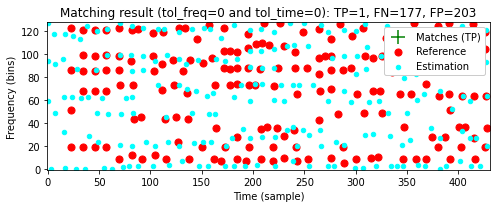

====== Reference: Original; Estimation: Noise ======


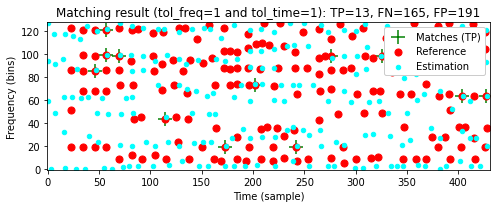

In [30]:


seconds_limit = 20.0


def match_binary_matrices_tol(C_ref, C_est, tol_freq=0, tol_time=0):
    """| Compare binary matrices with tolerance
    | Note: The tolerance parameters should be smaller than the minimum distance of
      peaks (1-entries in C_ref ad C_est) to obtain meaningful TP, FN, FP values

    Notebook: C7/C7S1_AudioIdentification.ipynb

    Args:
        C_ref (np.ndarray): Binary matrix used as reference
        C_est (np.ndarray): Binary matrix used as estimation
        tol_freq (int): Tolerance in frequency direction (vertical) (Default value = 0)
        tol_time (int): Tolerance in time direction (horizontal) (Default value = 0)

    Returns:
        TP (int): True positives
        FN (int): False negatives
        FP (int): False positives
        C_AND (np.ndarray): Boolean mask of AND of C_ref and C_est (with tolerance)
    """
    assert C_ref.shape == C_est.shape, "Dimensions need to agree"
    N = np.sum(C_ref)
    M = np.sum(C_est)
    # Expand C_est with 2D-max-filter using the tolerance parameters
    C_est_max = ndimage.maximum_filter(C_est, size=(2*tol_freq+1, 2*tol_time+1),
                                       mode='constant')
    C_AND = np.logical_and(C_est_max, C_ref)
    TP = np.sum(C_AND)
    FN = N - TP
    FP = M - TP
    return TP, FN, FP, C_AND

def compare_constellation_maps(fn_wav_D, fn_wav_Q, dist_freq = 11, dist_time = 5,
                               tol_freq = 1, tol_time = 1):
    Y_D = compute_spectrogram(fn_wav_D, duration=seconds_limit)
    Cmap_D = compute_constellation_map(Y_D, dist_freq, dist_time)
    Y_Q = compute_spectrogram(fn_wav_Q, duration=seconds_limit)
    Cmap_Q = compute_constellation_map(Y_Q, dist_freq, dist_time)

    TP, FN, FP, Cmap_AND = match_binary_matrices_tol(Cmap_D, Cmap_Q,
                                                     tol_freq=tol_freq, tol_time=tol_time)
    title=r'Matching result (tol_freq=%d and tol_time=%d): TP=%d, FN=%d, FP=%d' % \
        (tol_freq,tol_time, TP, FN, FP)
    fig, ax, im = plot_constellation_map(Cmap_AND, color='green', s=200, marker='+', title=title)
    n, k = np.argwhere(Cmap_D == 1).T
    ax.scatter(k, n, color='r', s=50, marker='o')
    n, k = np.argwhere(Cmap_Q == 1).T
    ax.scatter(k, n, color='cyan', s=20, marker='o')
    plt.legend(['Matches (TP)', 'Reference', 'Estimation'], loc='upper right', framealpha=1)
    plt.tight_layout()
    plt.show()


fn_wav_D = fdialog.selected
fn_wav_Q = '/home/kobi/tmpMusic/phoneSpeakerInRoom/crazy.mp3'
tol_freq = 0
tol_time = 0
print('====== Reference: Original; Estimation: Noise ======')
compare_constellation_maps(fn_wav_D, fn_wav_Q, tol_freq=tol_freq, tol_time=tol_time)

tol_freq = 1
tol_time = 1
print('====== Reference: Original; Estimation: Noise ======')
compare_constellation_maps(fn_wav_D, fn_wav_Q, tol_freq=tol_freq, tol_time=tol_time)

# fn_wav_Q = wav_dict['Coding'][-1]
# tol_freq = 1
# tol_time = 1
# print('====== Reference: Original; Estimation: Coding ======')
# compare_constellation_maps(fn_wav_D, fn_wav_Q, tol_freq=tol_freq, tol_time=tol_time)

# fn_wav_Q = wav_dict['Talking'][-1]
# tol_freq = 1
# tol_time = 1
# print('====== Reference: Original; Estimation: Talking ======')
# compare_constellation_maps(fn_wav_D, fn_wav_Q, tol_freq=tol_freq, tol_time=tol_time)


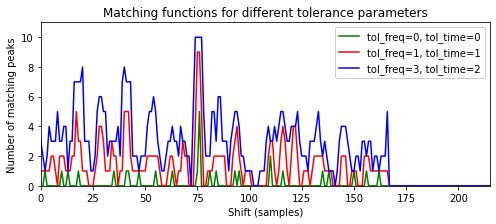

In [57]:
def compute_matching_function(C_D, C_Q, tol_freq=1, tol_time=1):
    """Computes matching function for constellation maps

    Notebook: C7/C7S1_AudioIdentification.ipynb

    Args:
        C_D (np.ndarray): Binary matrix used as dababase document
        C_Q (np.ndarray): Binary matrix used as query document
        tol_freq (int): Tolerance in frequency direction (vertical) (Default value = 1)
        tol_time (int): Tolerance in time direction (horizontal) (Default value = 1)

    Returns:
        Delta (np.ndarray): Matching function
        shift_max (int): Optimal shift position maximizing Delta
    """
    L = C_D.shape[1]
    N = C_Q.shape[1]
    M = L - N
    assert M >= 0, "Query must be shorter than document"
    Delta = np.zeros(L)
    for m in range(M + 1):
        C_D_crop = C_D[:, m:m+N]
        TP, FN, FP, C_AND = match_binary_matrices_tol(C_D_crop, C_Q,
                                                      tol_freq=tol_freq, tol_time=tol_time)
        Delta[m] = TP
    shift_max = np.argmax(Delta)
    return Delta, shift_max

dist_freq = 11
dist_time = 5

fn_wav_D = fdialog.selected
Y_D = compute_spectrogram(fn_wav_D, duration=seconds_limit)
Cmap_D = compute_constellation_map(Y_D, dist_freq, dist_time)

fn_wav_Q = '/home/kobi/tmpMusic/phoneSpeakerInRoom/crazy.mp3'

Y_Q = compute_spectrogram(fn_wav_Q, duration=seconds_limit)
Y_Q = Y_Q[:, 100:150]
Cmap_Q = compute_constellation_map(Y_Q, dist_freq, dist_time)

Delta_0, shift_max_0 = compute_matching_function(Cmap_D, Cmap_Q, tol_freq=0, tol_time=0)
Delta_1, shift_max_1 = compute_matching_function(Cmap_D, Cmap_Q, tol_freq=1, tol_time=1)
Delta_2, shift_max_2 = compute_matching_function(Cmap_D, Cmap_Q, tol_freq=2, tol_time=2)

y_max = Delta_2[shift_max_2] + 1
fig, ax, line = libfmp.b.plot_signal(Delta_0, ylim=[0, y_max], color='g',
                                     xlabel='Shift (samples)', ylabel='Number of matching peaks',
                                     figsize=(7, 3))
plt.title('Matching functions for different tolerance parameters')
ax.plot(Delta_1, color='r')
ax.plot(Delta_2, color='b')
plt.legend(['tol_freq=0, tol_time=0', 'tol_freq=1, tol_time=1',
            'tol_freq=3, tol_time=2'], loc='upper right', framealpha=1)
plt.show()


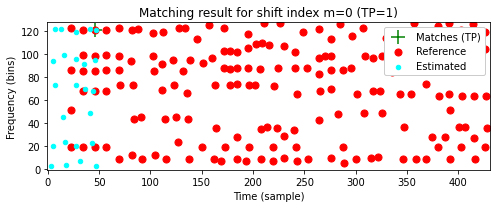

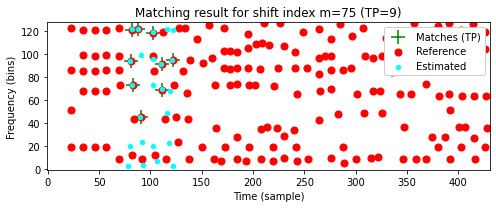

In [32]:

def plot_shifted_Cmap(Cmap_D, Cmap_Q, shift=0):
    Cmap_Q_extend = np.zeros(Cmap_D.shape)
    Cmap_Q_extend[:, shift:shift+Cmap_Q.shape[1]] = Cmap_Q
    TP, FN, FP, Cmap_AND = match_binary_matrices_tol(Cmap_D, Cmap_Q_extend,
                                                     tol_freq=1, tol_time=1)
    title=r'Matching result for shift index m=%d (TP=%d)' % (shift, TP)
    fig, ax, im = plot_constellation_map(Cmap_AND, color='green', s=200, marker='+', title=title)
    n, k = np.argwhere(Cmap_D == 1).T
    ax.scatter(k, n, color='r', s=50, marker='o')
    n, k = np.argwhere(Cmap_Q_extend == 1).T
    ax.scatter(k, n, color='cyan', s=20, marker='o')
    plt.legend(['Matches (TP)', 'Reference', 'Estimated'], loc='upper right', framealpha=1)
    plt.show()

plot_shifted_Cmap(Cmap_D, Cmap_Q, shift=0)
plot_shifted_Cmap(Cmap_D, Cmap_Q, shift=shift_max_1)


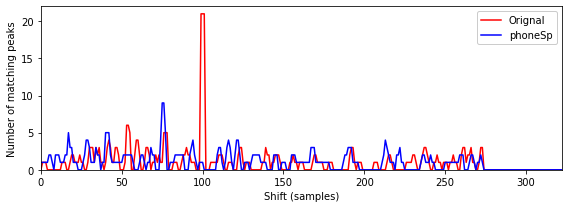

In [64]:

seconds_limit = 15.0

def compute_Delta(fn_wav_D, fn_wav_Q, seg_start=100, seg_end=150, dist_freq=11,
                  dist_time=5, tol_freq=1, tol_time=1):
    Y_D = compute_spectrogram(fn_wav_D, duration=seconds_limit)
    Cmap_D = compute_constellation_map(Y_D, dist_freq=dist_freq, dist_time=dist_time)
    Y_Q = compute_spectrogram(fn_wav_Q, duration=seconds_limit)
    Y_Q = Y_Q[:, seg_start:seg_end]
    Cmap_Q = compute_constellation_map(Y_Q, dist_freq=dist_freq, dist_time=dist_time)
    Delta, shift_max = compute_matching_function(Cmap_D, Cmap_Q,
                                                 tol_freq=tol_freq, tol_time=tol_time)
    return Delta, shift_max

fn_wav_Q = fdialog.selected
Delta_0, shift_max_0 = compute_Delta(fn_wav_D, fn_wav_Q)
fn_wav_Q = '/home/kobi/tmpMusic/phoneSpeakerInRoom/crazy.mp3'
# fn_wav_Q = '/home/kobi/tmpMusic/phoneSpeakerInRoom/7nat.mp3'
Delta_1, shift_max_1 = compute_Delta(fn_wav_D, fn_wav_Q)

y_max = Delta_0[shift_max_0] + 1
fig, ax, line = libfmp.b.plot_signal(Delta_0, ylim=[0, y_max], color='r',
                                     xlabel='Shift (samples)',
                                     ylabel='Number of matching peaks',
                                     figsize=(8, 3))
ax.plot(Delta_1, color='b')
plt.legend(['Orignal', 'phoneSp', 'Coding', 'Talking'], loc='upper right', framealpha=1)
plt.show()
